In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geemap import ml
from sklearn.ensemble import RandomForestClassifier

import geemap, ee

from geemap import cartoee
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import Line2D

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
    accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [4]:
%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../lib/')

In [5]:
%reload_ext autoreload
import sand_classification as sc
import quality_mosaic as qm
import train_val as tv

# Train a set of classifiers

In [6]:
test_split=0.3
seed_segmentation = 15

In [7]:
# filename = '../data/labels/gt-bands-resampled-s' + str(seed_segmentation)+'.xlsx'
filename = '../data/labels/23-06-26_gt-bands-cluster_median.xlsx'
filename

'../data/labels/23-06-26_gt-bands-cluster_median.xlsx'

In [8]:
X_train, X_test, y_train,  y_test = tv.split(filename, test_split=test_split)


     Unnamed: 0         ID   Latitude  Longitude Class        Date     Site  \
0           1.0  sedinet-1  18.459221 -65.987196  sand  2020-06-15  Coastal   
1           2.0  sedinet-2  38.665018 -75.067643  sand  2020-06-22  Coastal   
2           3.0  sedinet-3  38.665267 -75.067228  sand  2020-06-22  Coastal   
3           5.0  sedinet-5  39.792640 -74.093250  sand  2021-06-24  Coastal   
4           6.0  sedinet-6  39.792648 -74.092864  sand  2020-06-24  Coastal   
..          ...        ...        ...        ...   ...         ...      ...   
174         NaN   Zavala-7 -24.753306  34.798517  Sand  2023-05-11  coastal   
175         NaN   Zavala-8 -24.753467  34.798022  Sand  2023-05-11  coastal   
176         NaN   Zavala-9 -24.753653  34.797492  Sand  2023-05-11  coastal   
177         NaN  Zavala-11 -24.754006  34.796390  Sand  2023-05-11  coastal   
178         NaN  Zavala-14 -24.749152  34.800027  Sand  2023-05-11  coastal   

    ATT ID                                       Im

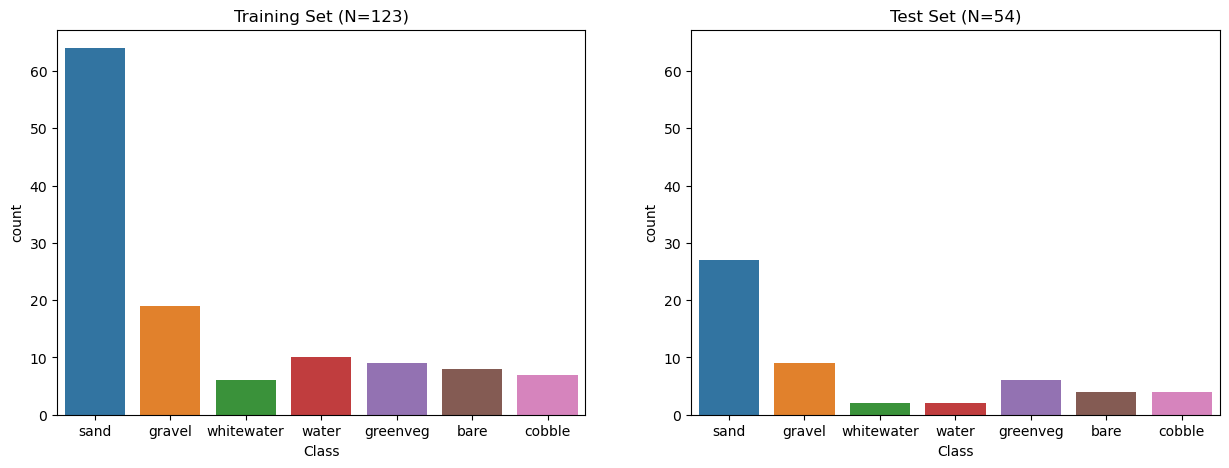

In [9]:
#plot the distribution of the classes in X_train and X_test using the column class_code
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='class_code', data=X_train, ax=ax[0])
sns.countplot(x='class_code', data=X_test, ax=ax[1])
ax[0].set_title('Training Set (N={})'.format(len(X_train)))
ax[1].set_title('Test Set (N={})'.format(len(X_test)))

ax[0].set_xticklabels(tv.class_labels)
ax[1].set_xticklabels(tv.class_labels)

ax[0].set_xlabel('Class')
ax[1].set_xlabel('Class')
#set their y axes to be the same size

ax[1].set_ylim(ax[0].get_ylim())
# plt.title('Label Distribution')

plt.show()


## Plot global locations of train/test samples

In [10]:
Map = geemap.Map()

Map.add_basemap('SATELLITE')

image = (
    ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
    .filter(ee.Filter.date('2022-04-01', '2022-05-01'))
    .select("NDVI")
    .median()
)

vis_params = {
    'min': 0.0,
    'max': 1.0,
    'palette': [
        'FFFFFF',
        'CE7E45',
        'DF923D',
        'F1B555',
        'FCD163',
        '99B718',
        '74A901',
        '66A000',
        '529400',
        '3E8601',
        '207401',
        '056201',
        '004C00',
        '023B01',
        '012E01',
        '011D01',
        '011301',
    ],
}
# Map.setCenter(-7.03125, 31.0529339857, 2)
# Map.addLayer(image, vis_params, 'MODIS NDVI')

countries = ee.FeatureCollection('users/giswqs/public/countries')
style = {"color": "00000088", "width": 1, "fillColor": "00000000"}
Map.addLayer(countries.style(**style), {}, "Countries")

ndvi = image.visualize(**vis_params)
blend = ndvi.blend(countries.style(**style))



Map.addLayer(blend, {}, "Blend")


train_locations, test_locations = [], []

for i, row in X_train.iterrows():
    train_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))

for i, row in X_test.iterrows():
    test_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))


#convert the list of features to a feature collection
train_samples = ee.FeatureCollection(train_locations)
test_samples = ee.FeatureCollection(test_locations)

Map.addLayer(train_samples, {'color':'blue'}, 'training locations')
Map.addLayer(test_samples, {'color':'red'}, 'testing locations')




Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

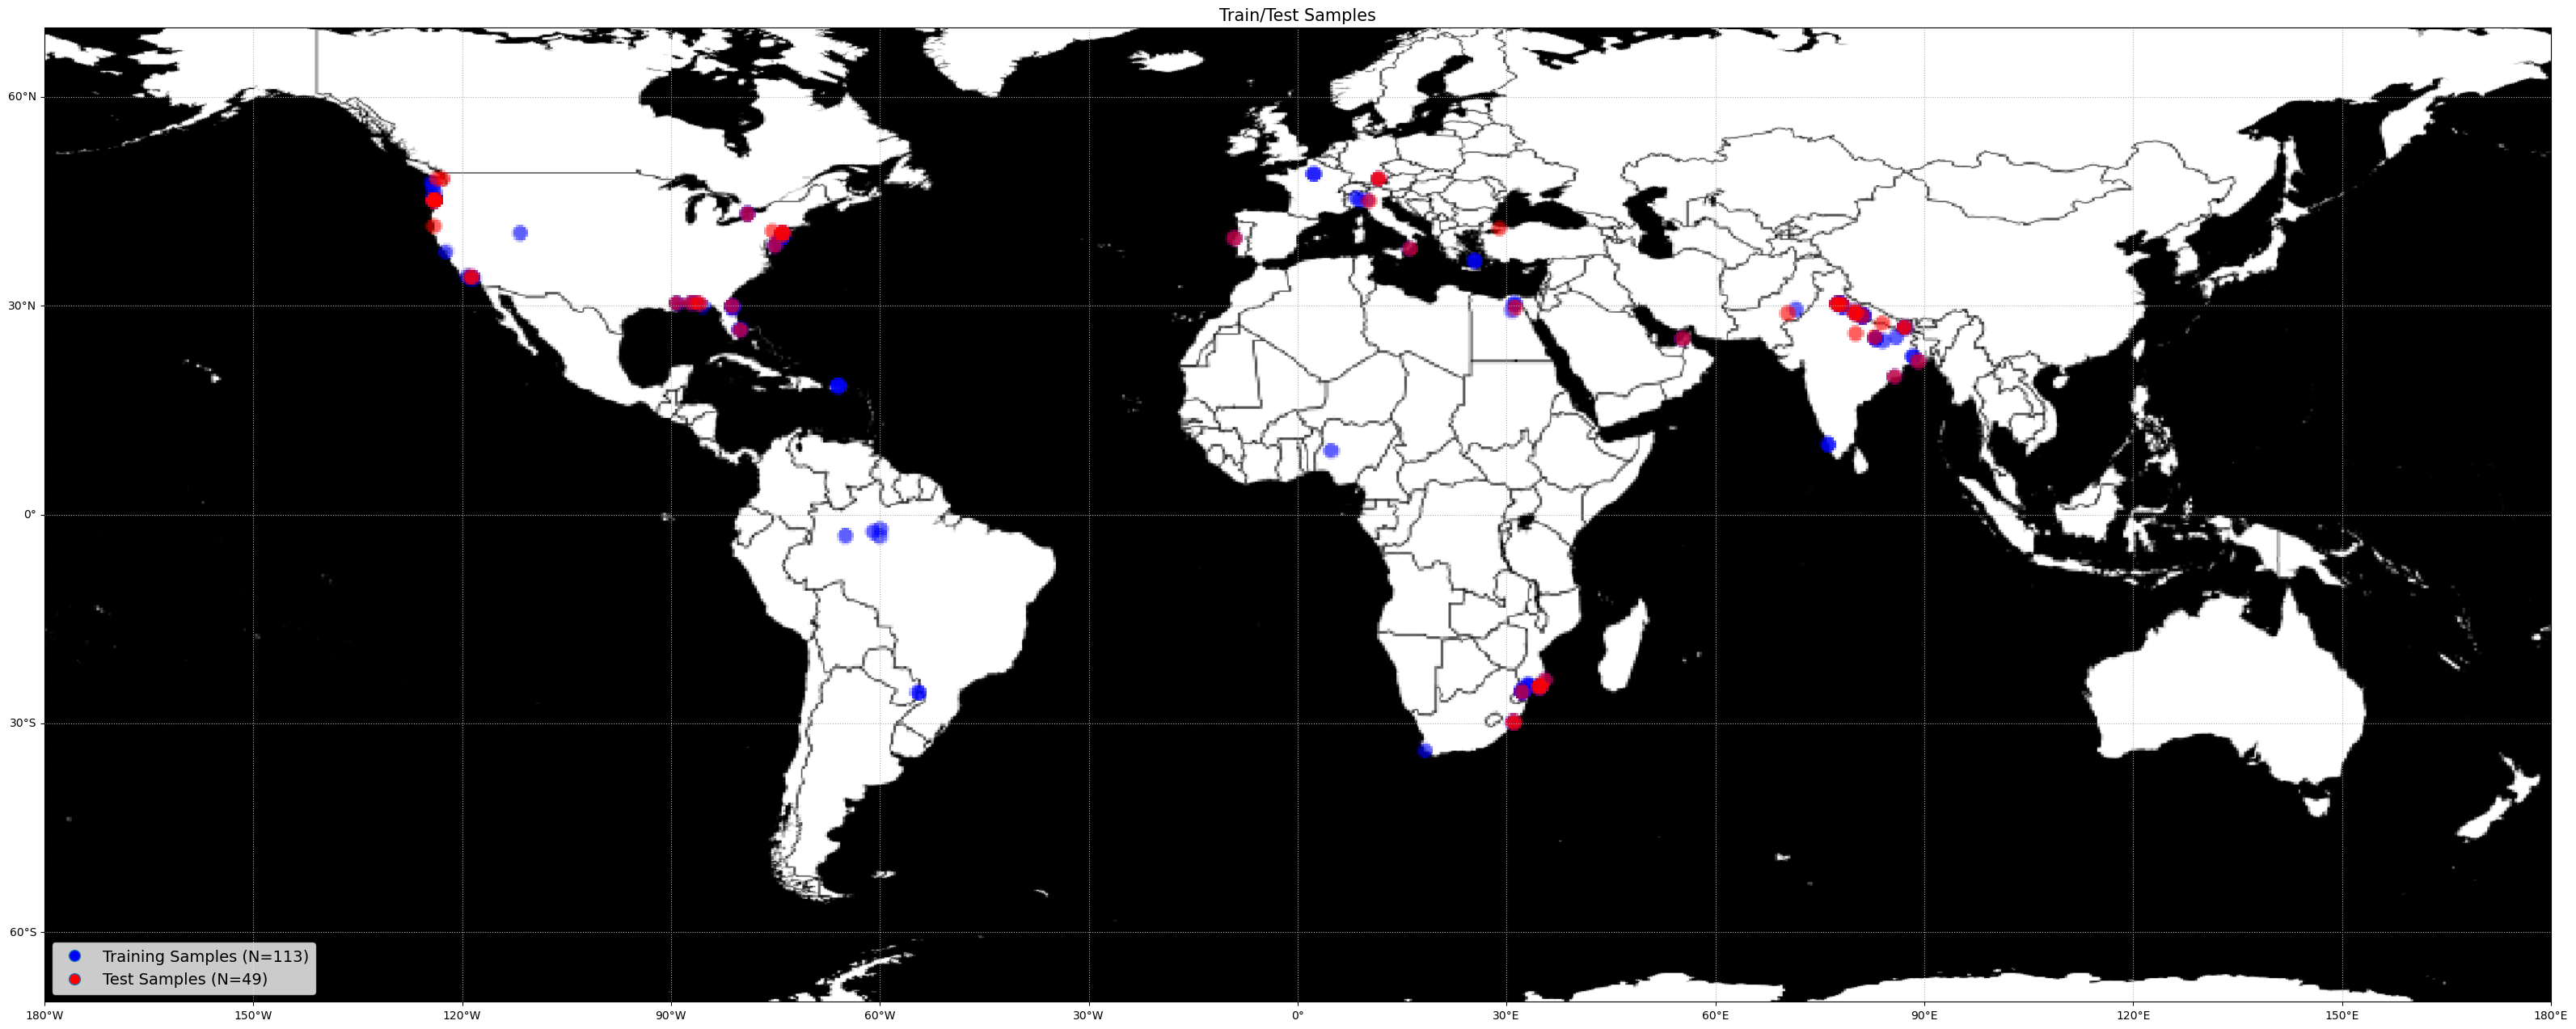

In [11]:
# specify region to focus on
bbox = [180, -70, -180, 70]
basemap = cimgt.Stamen('watercolor')
basemap = 'ROADMAP'
basemap = cimgt.Stamen('terrain-background')
basemap = cimgt.Stamen('toner-background')
# basemap = 'SATELLITE'

countries = ee.FeatureCollection('users/giswqs/public/countries')
countries_layer = countries.draw(color = 'black', strokeWidth = 1)

train_locations, test_locations = [], []

for i, row in X_train.iterrows():
    train_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))

for i, row in X_test.iterrows():
    test_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))


#convert the list of features to a feature collection
train_samples = ee.FeatureCollection(train_locations)
test_samples = ee.FeatureCollection(test_locations)

fig = plt.figure(figsize=(40, 20))
projection = ccrs.EqualEarth(central_longitude=-180)
# plot the result with cartoee using a PlateCarre projection (default)
# ax = cartoee.get_map(blend, region=bbox, projection=projection, basemap=basemap)

ax = cartoee.get_map(train_samples.draw(color = 'blue', strokeWidth = 0, pointRadius=3), region=bbox, projection=projection, basemap=basemap)
# cartoee.add_layer(ax, train_samples.draw(color = 'blue', strokeWidth = 0, pointRadius=3), region=bbox)
cartoee.add_layer(ax, test_samples.draw(color = 'red', strokeWidth = 0, pointRadius=3), region=bbox)

cartoee.add_gridlines(ax, interval=30, linestyle=":") #xtick_rotation=0, 


legend_elements = [
                Line2D([],[],marker="o",
                    markerfacecolor='blue',
                    label="Training Samples (N=113)",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([],[],marker="o",
                    markerfacecolor='red',
                    label="Test Samples (N=49)",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls="")          
            ]
legend = cartoee.add_legend(ax, legend_elements, loc='lower left')


ax.set_title(label='Train/Test Samples', fontsize=15)

plt.savefig('../data/labels/sample-locations.jpg', dpi=600)
plt.show()

# Hyperparameter Tuning

In [12]:
X_train = X_train.drop(['Latitude', 'Longitude', 'class_code'], axis=1)
X_test  = X_test.drop(['Latitude', 'Longitude', 'class_code'], axis=1)
X_train, X_test, y_train, y_test

(       B2_median    B3_median  B4_median    B8_median  B8A_median  \
 176   597.000000   961.250000     1154.0  2846.000000      3071.0   
 121  2321.200000  2596.000000     2869.6  3109.600000      3145.0   
 14   2489.600000  2568.333333     2613.0  2966.000000      2928.5   
 172  1689.000000  2438.000000     3108.0  3619.500000      3648.0   
 129   222.333333   449.000000      219.0  4158.000000      4302.0   
 ..           ...          ...        ...          ...         ...   
 153  2304.000000  2778.000000     3036.0  3380.000000      3238.0   
 98   1407.000000  1601.000000     1360.0   810.000000       731.5   
 16   3426.500000  3490.000000     3541.0  4039.625000      3975.0   
 74   2042.000000  2250.000000     2360.0  2630.000000      2628.0   
 82    884.117647  1144.000000     1290.0  1072.791667      1003.7   
 
       B11_median   B12_median  VV_median  VH_median  mTGSI_median  BSI_median  \
 176  3044.000000  2335.000000 -11.982580 -17.947693      0.006877    0.0980

But before we can do that, let's remap the classes manually, so the scores we care about are confusion b/w sand, gravel and others, instead of the confusion between say greenveg and water reducing the metrics of interest

## Random Grid Search CV

In [13]:
# Instantiate the grid search model
scorers = {
    # 'precision_score': make_scorer(precision_score),
    # 'recall_score': make_scorer(recall_score),
    # 'accuracy_score': make_scorer(accuracy_score),
    'remapped_f1_score': make_scorer(tv.remapped_f1_score),
    'remapped_accuracy_score': make_scorer(tv.remapped_accuracy_score),
    'f1_score': make_scorer(tv.f1_score),
    'accuracy_score': make_scorer(tv.accuracy_score)
}

In [14]:
def random_search_wrapper(clf, X_train, X_test, y_train, y_test, random_grid, refit_score='remapped_f1_score', 
                            k_fold='normal', n_iter=100, random_state=13, n_splits=10, remap=True):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    if k_fold == 'normal':
        skf = KFold(n_splits=n_splits)
    else:
        skf = StratifiedKFold(n_splits=n_splits)

    random_search = RandomizedSearchCV(clf, param_distributions = random_grid, n_iter = n_iter, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, random_state=random_state)
    
    random_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = random_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(random_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    # print(pd.DataFrame(cm))

    

    if (remap):
        tv.display_cm(cm)

        remapped_cm = tv.remap_cm(y_test, y_pred)    
        tv.display_cm(remapped_cm, tv.remapped_class_labels)
        print("Remapped F1 Score :{:6.4f} | remapped accuracy score: {:6.4f}".format(tv.remapped_f1_score(y_test, y_pred), tv.remapped_accuracy_score(y_test, y_pred)))
        
        return random_search, cm, remapped_cm 

    else:
        tv.display_cm(cm, class_labels=tv.remapped_class_labels)

        print("F1 Score (S+G only):{:6.4f} | Overall Accuracy : {:6.4f}".format(tv.f1_score(y_test, y_pred), tv.accuracy_score(y_test, y_pred)))
        

        return random_search, cm

In [15]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 30)],
               'max_features': [None], #['sqrt', None],
               'max_depth': [int(x) for x in np.linspace(50, 300, num = 20)],
               'min_samples_split': [2, 3, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True]}
print(random_grid)


{'n_estimators': [1000, 1068, 1137, 1206, 1275, 1344, 1413, 1482, 1551, 1620, 1689, 1758, 1827, 1896, 1965, 2034, 2103, 2172, 2241, 2310, 2379, 2448, 2517, 2586, 2655, 2724, 2793, 2862, 2931, 3000], 'max_features': [None], 'max_depth': [50, 63, 76, 89, 102, 115, 128, 142, 155, 168, 181, 194, 207, 221, 234, 247, 260, 273, 286, 300], 'min_samples_split': [2, 3, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


Best params for remapped_f1_score
{'n_estimators': 1965, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True}

Confusion matrix of Random Forest optimized for remapped_f1_score on the test data:


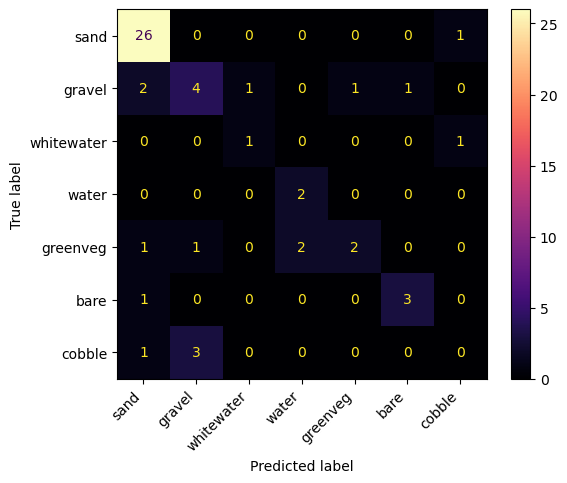

0  1   2
0  26  0   1
1   2  4   3
2   3  4  11

| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.83871  | 0.962963 |   0.896552 |        27 |
| gravel  |    0.5      | 0.444444 |   0.470588 |         9 |
| other   |    0.733333 | 0.611111 |   0.666667 |        18 |


class           precision              recall             f1-score support
0    sand  0.8387096774193549  0.9629629629629629    0.896551724137931      27
1  gravel                 0.5  0.4444444444444444  0.47058823529411764       9
2   other  0.7333333333333333  0.6111111111111112   0.6666666666666666      18

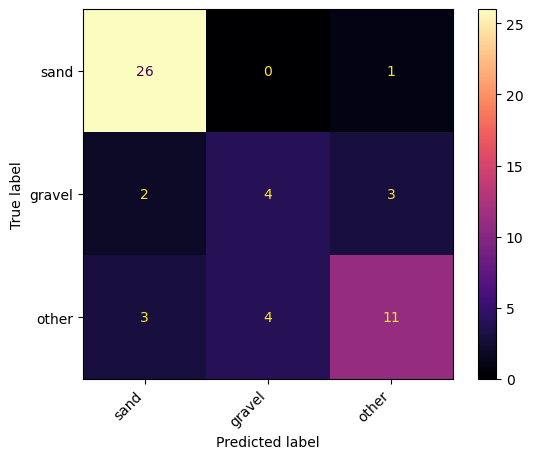

Remapped F1 Score :0.7901 | remapped accuracy score: 0.7593


In [16]:
RF = RandomForestClassifier(n_jobs=-1)

random_search_clf, cm_rand, remapped_cm_rand = random_search_wrapper(RF, X_train, X_test, y_train, y_test, random_grid, n_iter=50, n_splits=5)

## Grid Search

In [15]:
def grid_search_wrapper(clf, X_train, X_test, y_train, y_test, param_grid, verbose=3, 
                        refit_score='remapped_f1_score', k_fold='normal', remap=True):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    if k_fold == 'normal':
        skf = KFold(n_splits=10)
    else:
        skf = StratifiedKFold(n_splits=10)
        
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, verbose=verbose)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)


    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    print(pd.DataFrame(cm))

    if (remap):
        remapped_cm = tv.remap_cm(y_test, y_pred)

        tv.display_cm(cm)
        tv.display_cm(remapped_cm, tv.remapped_class_labels)

        print("Remapped F1 Score (s+g only): {:6.4f} | remapped overall accuracy: {:6.4f}".format(tv.remapped_f1_score(y_test, y_pred), tv.remapped_accuracy_score(y_test, y_pred)))
        
        print('Best params for {}'.format(refit_score))
        print(grid_search.best_params_)
        
        return grid_search, cm, remapped_cm

    else:
        tv.display_cm(cm, class_labels=tv.remapped_class_labels)

        print("F1 Score (S+G only):{:6.4f} | Overall Accuracy: {:6.4f}".format(tv.f1_score(y_test, y_pred), tv.accuracy_score(y_test, y_pred)))
        
        print('Best params for {}'.format(refit_score))
        print(grid_search.best_params_)
        
        return grid_search, cm

In [16]:
n_estimators = [int(x) for x in np.linspace(1000, 2000, num = 11)]
# [int(x) for x in np.linspace(30, 150, num = 10)]
# [int(x) for x in np.logspace(1.8, 3.33, num = 30)]
# {'n_estimators': 1178, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 89, 'bootstrap': True}

n_estimators

[1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

In [17]:
param_grid = {
    'bootstrap': [True], #, False],
    'max_depth': [int(x) for x in np.linspace(50, 150, num = 10)],
    'max_features': [None],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [3,4,10],
    'n_estimators': n_estimators    
}


In [18]:
RF = RandomForestClassifier(n_jobs=-1)
grid_search_clf, cm, remapped_cm = grid_search_wrapper(RF, X_train, X_test, y_train, y_test, param_grid, verbose=3)


Fitting 10 folds for each of 990 candidates, totalling 9900 fits
[CV 1/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=1000; accuracy_score: (train=1.000, test=0.769) f1_score: (train=1.000, test=0.900) remapped_accuracy_score: (train=1.000, test=0.769) remapped_f1_score: (train=1.000, test=0.900) total time=   3.9s
[CV 2/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=1000; accuracy_score: (train=1.000, test=0.615) f1_score: (train=1.000, test=0.769) remapped_accuracy_score: (train=1.000, test=0.692) remapped_f1_score: (train=1.000, test=0.769) total time=   3.9s
[CV 5/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=1000; accuracy_score: (train=0.982, test=0.833) f1_score: (train=0.994, test=0.942) remapped_accuracy_score: (train=0.991, test=0.917) remapped_f1_score: (train=0.994, test=0.942) total 

KeyboardInterrupt: 

In [ ]:
grid_search_clf.best_params_

{'bootstrap': True,
 'max_depth': 61,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 2350}

### Remapped Confusion Matrix

In [36]:
y_pred = grid_search_clf.predict(X_test.values)
remapped_cm = tv.remap_cm(y_test, y_pred)

0  1   2
0  26  0   1
1   2  4   3
2   3  4  11

| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.83871  | 0.962963 |   0.896552 |        27 |
| gravel  |    0.5      | 0.444444 |   0.470588 |         9 |
| other   |    0.733333 | 0.611111 |   0.666667 |        18 |


class           precision              recall             f1-score support
0    sand  0.8387096774193549  0.9629629629629629    0.896551724137931      27
1  gravel                 0.5  0.4444444444444444  0.47058823529411764       9
2   other  0.7333333333333333  0.6111111111111112   0.6666666666666666      18

In [37]:
sum(sum(remapped_cm))

54

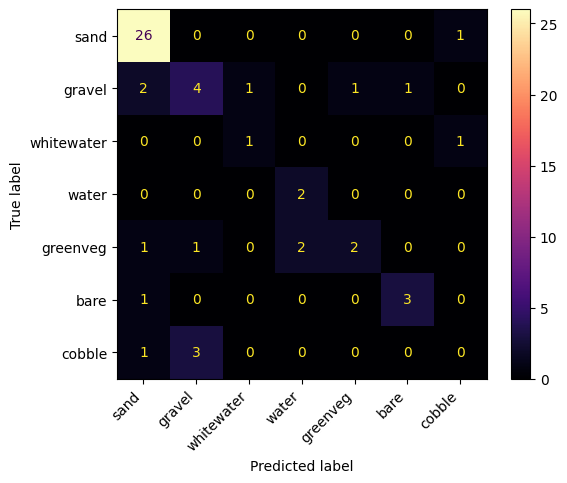

In [38]:
tv.display_cm(cm)

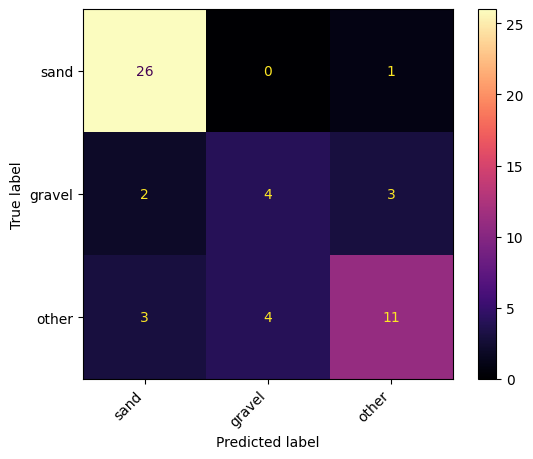

In [39]:
tv.display_cm(remapped_cm, class_labels=['sand','gravel','other'])

# 3-class Classification

We first map the 7 classes to 3 classes (sand, gravel and others) and then train a classifier on the remapped classes. This should give us a better idea of how the classifier is performing on the classes we care about, especially the feature importance.

## Collapse dataset to 3 classes

In [18]:
y_train, y_test = tv.remap_pd_classes(y_train), tv.remap_pd_classes(y_test)

## Random Search

In [22]:
y_train_remap, y_test_remap = tv.remap_pd_classes(y_train), tv.remap_pd_classes(y_test)

In [23]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 2500, num = 24)],
               'max_features': [None], #['sqrt', None],
               'max_depth': [int(x) for x in np.linspace(50, 300, num = 20)],
               'min_samples_split': [2, 3, 5],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True]}
print(random_grid)

{'n_estimators': [1000, 1065, 1130, 1195, 1260, 1326, 1391, 1456, 1521, 1586, 1652, 1717, 1782, 1847, 1913, 1978, 2043, 2108, 2173, 2239, 2304, 2369, 2434, 2500], 'max_features': [None], 'max_depth': [50, 63, 76, 89, 102, 115, 128, 142, 155, 168, 181, 194, 207, 221, 234, 247, 260, 273, 286, 300], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


Best params for f1_score
{'n_estimators': 1913, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 128, 'bootstrap': True}

Confusion matrix of Random Forest optimized for f1_score on the test data:


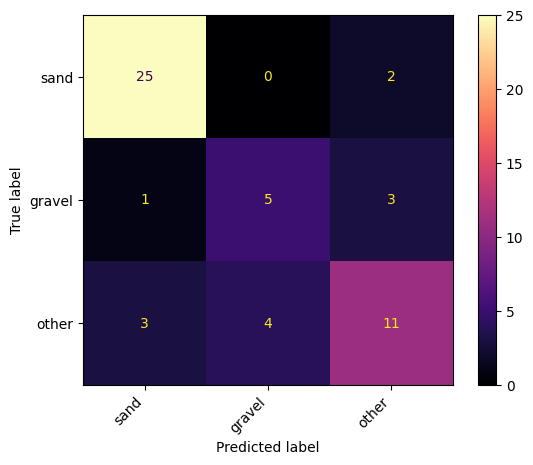

F1 Score (S+G only):0.8085 | Overall Accuracy : 0.7593


In [77]:
RF_remap = RandomForestClassifier(n_jobs=-1)

random_search_clf, cm_rand = random_search_wrapper(RF_remap, X_train, X_test, y_train_remap, y_test_remap, 
                                                                    random_grid, refit_score='f1_score', n_iter=50, n_splits=5, remap=False)

## Grid Search

In [23]:
n_estimators = [int(x) for x in np.linspace(2500, 3500, num = 11)]
n_estimators

[2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500]

In [24]:
param_grid = {
    'bootstrap': [True], #, False],
    'max_depth': [int(x) for x in np.linspace(30, 150, num = 10)],
    'max_features': [None],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [3,4,5],
    'n_estimators': n_estimators    
}


Fitting 10 folds for each of 990 candidates, totalling 9900 fits
[CV 4/10] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=2500; accuracy_score: (train=0.982, test=0.833) f1_score: (train=0.986, test=0.846) remapped_accuracy_score: (train=0.982, test=0.833) remapped_f1_score: (train=0.979, test=0.795) total time=   2.7s
[CV 6/10] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=2500; accuracy_score: (train=0.991, test=0.667) f1_score: (train=0.993, test=0.769) remapped_accuracy_score: (train=0.991, test=0.667) remapped_f1_score: (train=0.986, test=0.385) total time=   2.8s
[CV 1/10] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=3, n_estimators=2500; accuracy_score: (train=0.982, test=0.769) f1_score: (train=0.986, test=0.900) remapped_accuracy_score: (train=0.982, test=0.769) remapped_f1_score: (train=0.980, test=0.450) total 

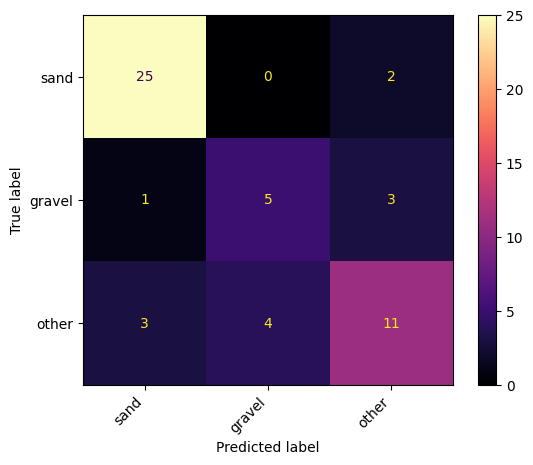

F1 Score (S+G only):0.8085 | Overall Accuracy: 0.7593
Best params for f1_score
{'bootstrap': True, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 3200}


In [25]:
RF_remap = RandomForestClassifier(n_jobs=-1)
grid_search_clf, cm = grid_search_wrapper(RF_remap, X_train, X_test, y_train_remap, y_test_remap, 
                                          param_grid, verbose=3, refit_score='f1_score', remap=False)

In [26]:
display(pd.DataFrame(cm))
display(round(tv.metrics_table(cm, tv.remapped_class_labels)))

0  1   2
0  25  0   2
1   1  5   3
2   3  4  11

| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.862069 | 0.925926 |   0.892857 |        27 |
| gravel  |    0.555556 | 0.555556 |   0.555556 |         9 |
| other   |    0.6875   | 0.611111 |   0.647059 |        18 |


class           precision              recall            f1-score support
0    sand  0.8620689655172413  0.9259259259259259  0.8928571428571429      27
1  gravel  0.5555555555555556  0.5555555555555556  0.5555555555555556       9
2   other              0.6875  0.6111111111111112  0.6470588235294118      18

# Run some tests on the best model in GEE

### Convert to a GEE model

In [17]:
_RF = random_search_clf.best_estimator_
# _RF = grid_search_clf.best_estimator_

In [18]:
RF_gee, trees = tv.sklearn_rf_to_gee(_RF)
RF_gee.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 76 9999 9999 (8.795501262514264)\n  2) B12_median <= 2046.000000 76 0.7195 1\n    4) NDWI_median <= -0.405646 5 0.0000 6 *\n    5) NDWI_median > -0.405646 21 0.7612 4\n      10) B8A_median <= 828.500000 7 0.0000 4 *\n      11) B8A_median > 828.500000 16 0.6944 4\n        22) B4_median <= 2429.642883 9 0.6122 5\n          44) B3_median <= 776.097229 1 0.0000 1 *\n          45) B3_median > 776.097229 6 0.3704 5\n            90) mTGSI_median <= 0.045343 4 0.0000 5 *\n            91) mTGSI_median > 0.045343 1 0.0000 7 *\n        23) B4_median > 2429.642883 3 0.0000 3 *\n  3) B12_median > 2046.000000 76 0.7195 1\n    6) VV_median <= -13.131000 55 0.5222 1\n      12) NDWI_median <= -0.056935 31 0.1738 1\n        24) NDWI_median <= -0.062636 26 0.0000 1 *\n        25) NDWI_median > -0.062636 2 0.4444 1 *\n      13) NDWI_median > -0.056935 3 0.3200 2 *\n    7) VV_median > -13.131000 55 0.5222 1\n      14) mTGSI_median <= 0.0

In [19]:
roi = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_aoi')
upper = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_upper_aoi')
lower = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_lower_aoi')
gst = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_region')


In [20]:
date = '2022-12-07' #from analysis in river_sand_flooding_gst_ganga GEE 
max_search_window_months = 2
median_samples = 5
mosaic_method = 'median'

lon, lat = 78.19376654, 29.74481053
gst_pt = ee.Geometry.Point([lon, lat])

# mining_centroids = ee.FeatureCollection('projects/gee-sand/assets/bihar_sand_banks_centroids')

s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=True)
s1_s2.bandNames()


Search window from 2022-10-07 to 2023-02-07


In [29]:
Map = geemap.Map()
Map.centerObject(roi, 12)
# Map.add_basemap('SATELLITE')
# Map.add_basemap('Stamen.Toner')
# Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
# Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI', False)
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')


Map

Map(center=[29.69879481189179, 78.13664798282139], controls=(WidgetControl(options=['position', 'transparent_b…

In [30]:
snicBands = tv.apply_snic_obia(image=s1_s2, roi=roi, size_segmentation=seed_segmentation, Map=Map)

print(snicBands.bandNames().getInfo())
# classy_RF = snicBands.classify(RF_gee)


#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# print(classy_RF.getInfo())

Map.addLayer(
    classy_RF,
    tv.classy_vizParams,
    'classification',
)

Map.add_legend(title="Classes", legend_dict=tv.legend_dict, position="bottomright")


['B2_median', 'B3_median', 'B4_median', 'B8_median', 'B8A_median', 'B11_median', 'B12_median', 'VV_median', 'VH_median', 'mTGSI_median', 'BSI_median', 'NDWI_median']
['B2_median', 'B3_median', 'B4_median', 'B8_median', 'B8A_median', 'B11_median', 'B12_median', 'VV_median', 'VH_median', 'mTGSI_median', 'BSI_median', 'NDWI_median']


# Save To CLoud

In [26]:
model_params = grid_search_clf.best_params_

In [ ]:
model_params

{'bootstrap': True,
 'max_depth': 50,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 1700}

In [28]:
tree_name = 'RF_sklearn_seg{:d}_n{:d}_d{:d}_msl{:d}_mss{:d}_mf-{:s}_b{:s}'.format(seed_segmentation, model_params['n_estimators'], 
                                                                                  model_params['max_depth'], model_params['min_samples_leaf'], 
                                                                                  model_params['min_samples_split'], str(model_params['max_features']), 
                                                                                  str(model_params['bootstrap']))
tree_name

'RF_sklearn_seg15_n1700_d50_msl2_mss4_mf-None_bTrue'

In [29]:
tree_name = 'RF_sklearn_seg10_n1700_d50_msl2_mss4_mf-None_bTrue'

In [ ]:
tv.save_trees_gee(trees,tree_name)

projects/gee-sand/assets/RF_sklearn_seg10_n2500_d30_msl2_mss4_mf-None_bTrue


In [68]:
cm

array([[21,  0,  0,  0,  0,  0,  0],
       [ 3,  7,  0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0],
       [ 4,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0],
       [ 1,  2,  0,  0,  0,  0,  0]])

In [74]:
sum(sum(cm))

49

In [71]:
remap_cm = tv.remap_cm(cm)


0  1  2
0  21  0  0
1   3  7  2
2   5  2  8

| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.724138 | 1        |   0.84     |        21 |
| gravel  |    0.777778 | 0.583333 |   0.666667 |        12 |
| other   |    0.8      | 0.533333 |   0.64     |        15 |


class           precision              recall            f1-score support
0    sand  0.7241379310344828                 1.0  0.8400000000000001      21
1  gravel  0.7777777777777778  0.5833333333333334  0.6666666666666666      12
2   other                 0.8  0.5333333333333333                0.64      15

In [75]:
sum(sum(remap_cm))

48

## Feature Importance

{'bootstrap': True, 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1133}

In [206]:
RF = RandomForestClassifier(n_estimators=1133, bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=2)
RF = RF.fit(X_train, y_train)

In [73]:
importances = _RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)


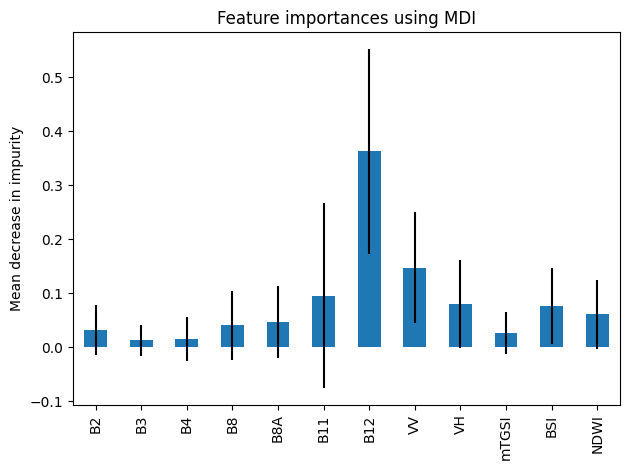

In [74]:
forest_importances = pd.Series(importances, index=qm.USEFUL_BANDS)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Based on feature permutation

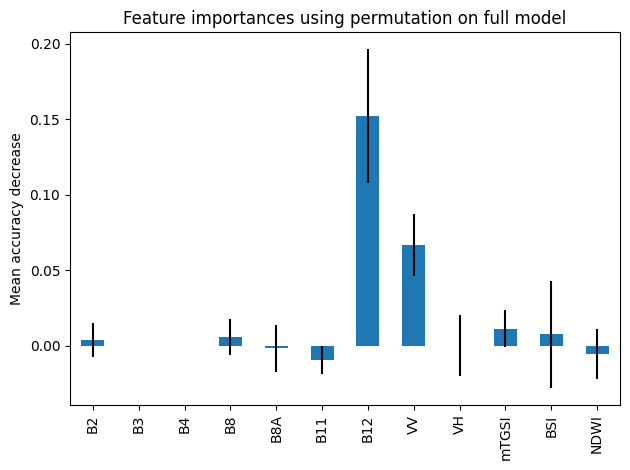

In [76]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    _RF, X_test.values, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=qm.USEFUL_BANDS)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()